In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from sklearn.metrics import pairwise_distances
from scipy.stats import kendalltau

from datetime import datetime

In [2]:
mnist_dataset = tf.keras.datasets.mnist
(full_train_images, full_train_labels), (full_test_images, full_test_labels) = mnist_dataset.load_data()

train_images = full_train_images[(full_train_labels == 1) | (full_train_labels == 7)]
train_labels = full_train_labels[(full_train_labels == 1) | (full_train_labels == 7)]

test_images = full_test_images[(full_test_labels == 1) | (full_test_labels == 7)]
test_labels = full_test_labels[(full_test_labels == 1) | (full_test_labels == 7)]

train_images = train_images / 255.0
test_images = test_images / 255.0

In [3]:
influence_data = np.load("../output/influence_model_on_binary_mnist.npz")
influence_values = influence_data["influence_values"]
theta_relatif_values = influence_data["theta_relatif_values"]
l_relatif_values = influence_data["l_relatif_values"]

representer_data = np.load("../output/representer_model_on_binary_mnist.npz")
representer_values = representer_data["representer_values"]
# Positive pre-activation values are excitatory towards label '7', inhibitive towards label '1', and vice versa.
representer_values[:, test_labels == 1] = -representer_values[:, test_labels == 1]

In [4]:
(num_training_points, num_test_points) = influence_values.shape
print("{} training points, {} test points.".format(num_training_points, num_test_points))

13007 training points, 2163 test points.


In [5]:
print("{} training points with label \'1\', {} with label \'7\'.".format(
    np.count_nonzero(train_labels == 1), np.count_nonzero(train_labels == 7)
))
print("{} test points with label \'1\', {} with label \'7\'.".format(
    np.count_nonzero(test_labels == 1), np.count_nonzero(test_labels == 7)
))

6742 training points with label '1', 6265 with label '7'.
1135 test points with label '1', 1028 with label '7'.


## Visualising Most Influential Points

In [6]:
influence_idxs = np.argsort(influence_values, axis=0)
theta_relatif_idxs = np.argsort(theta_relatif_values, axis=0)
l_relatif_idxs = np.argsort(l_relatif_values, axis=0)

# Positive representer values are helpful, opposite to influence values.
representer_idxs = np.flip(np.argsort(representer_values, axis=0))

In [7]:
def disp_most_influential(idxs):
    
    num_test_points_to_show = 8
    num_most_influential_to_show = 3
    
    pos_idxs = idxs
    neg_idxs = np.flip(pos_idxs, axis=0)
    
    fig, ax = plt.subplots(
        num_test_points_to_show,
        (2*num_most_influential_to_show+3),
        subplot_kw={'xticks':[], 'yticks':[]},
        figsize=(12, 9)
    )
    fig.subplots_adjust(hspace=0.4)

    ax[0, 0].set_title("Test Point", fontdict={'fontsize': 14})
    ax[0, (num_most_influential_to_show+3)//2].set_title("Most Positive Examples", fontdict={'fontsize': 14})
    ax[0, (3*num_most_influential_to_show+5)//2].set_title("Most Negative Examples", fontdict={'fontsize': 14})

    for i in range(num_test_points_to_show):
        ax[i, 0].imshow(test_images[i], cmap=plt.cm.binary)
        ax[i, 0].set_xlabel("Label: {}".format(test_labels[i]))
        
        ax[i, 1].set_visible(False)
        ax[i, num_most_influential_to_show+2].set_visible(False)
        
        for j in range(num_most_influential_to_show):
            ax[i, j+2].imshow(train_images[pos_idxs[j, i]], cmap=plt.cm.binary)
            ax[i, j+2].set_xlabel("Label: {}".format(train_labels[pos_idxs[j, i]]))
            # ax[i, j+2].set_ylabel("idx: {}".format(pos_idxs[j, i]))            
            ax[i, num_most_influential_to_show+j+3].imshow(train_images[neg_idxs[j, i]], cmap=plt.cm.binary)            
            ax[i, num_most_influential_to_show+j+3].set_xlabel("Label: {}".format(train_labels[neg_idxs[j, i]]))
            # ax[i, num_most_influential_to_show+j+3].set_ylabel("idx: {}".format(neg_idxs[j, i]))

### Influence Functions

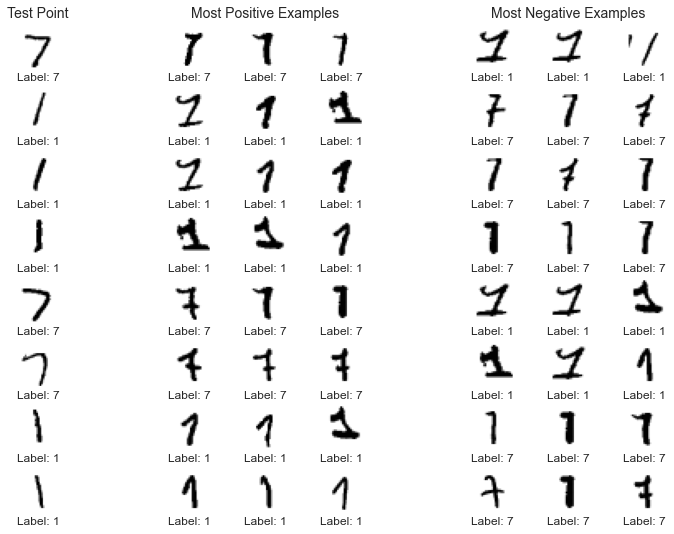

In [8]:
disp_most_influential(influence_idxs)

### $\theta$-Relatif

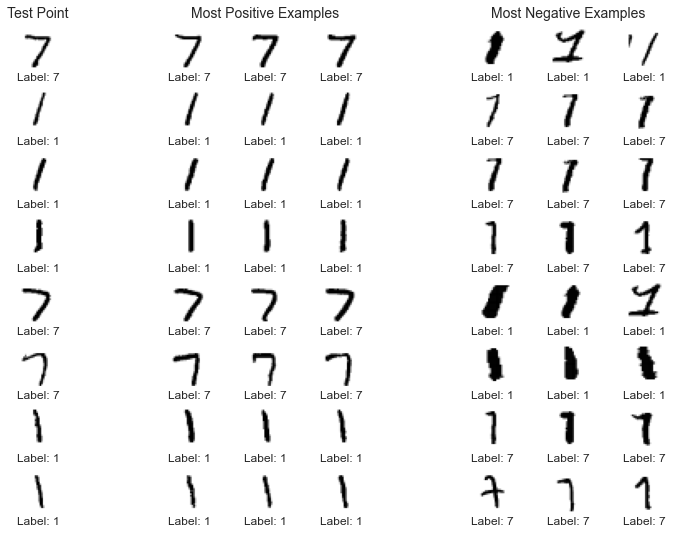

In [9]:
disp_most_influential(theta_relatif_idxs)

### $l$-Relatif

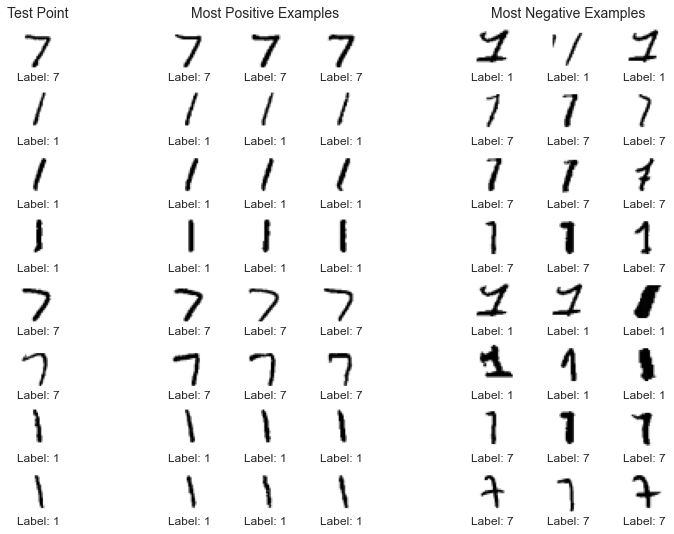

In [10]:
disp_most_influential(l_relatif_idxs)

### Representer Points

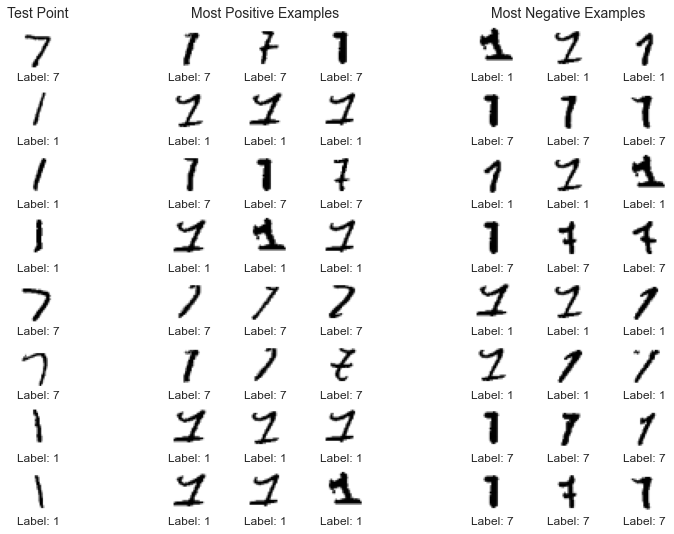

In [11]:
disp_most_influential(representer_idxs)

## Comparison Between Multiple Approaches

In [12]:
def disp_pair(idxs_0, idxs_1, title_0, title_1):
    
    num_test_points_to_show = 5
    num_most_influential_to_show = 3
    
    fig, ax = plt.subplots(
        num_test_points_to_show,
        (2*num_most_influential_to_show+3),
        subplot_kw={'xticks':[], 'yticks':[]},
        figsize=(12, 9)
    )
    fig.subplots_adjust(hspace=0.4)

    ax[0, 0].set_title("Test Point", fontdict={'fontsize': 14})
    ax[0, (num_most_influential_to_show+3)//2].set_title(title_0, fontdict={'fontsize': 14})
    ax[0, (3*num_most_influential_to_show+5)//2].set_title(title_1, fontdict={'fontsize': 14})

    for i in range(num_test_points_to_show):
        ax[i, 0].imshow(test_images[i], cmap=plt.cm.binary)
        ax[i, 0].set_xlabel("Label: {}".format(test_labels[i]))
        
        ax[i, 1].set_visible(False)
        ax[i, num_most_influential_to_show+2].set_visible(False)
        
        for j in range(num_most_influential_to_show):
            ax[i, j+2].imshow(train_images[idxs_0[j, i]], cmap=plt.cm.binary)            
            ax[i, j+2].set_xlabel("Label: {}".format(train_labels[idxs_0[j, i]]))
            # ax[i, j+2].set_ylabel("idx: {}".format(idxs_0[j, i]))
            ax[i, num_most_influential_to_show+j+3].imshow(train_images[idxs_1[j, i]], cmap=plt.cm.binary)
            ax[i, num_most_influential_to_show+j+3].set_xlabel("Label: {}".format(train_labels[idxs_1[j, i]]))
            # ax[i, num_most_influential_to_show+j+3].set_ylabel("idx: {}".format(idxs_1[j, i]))

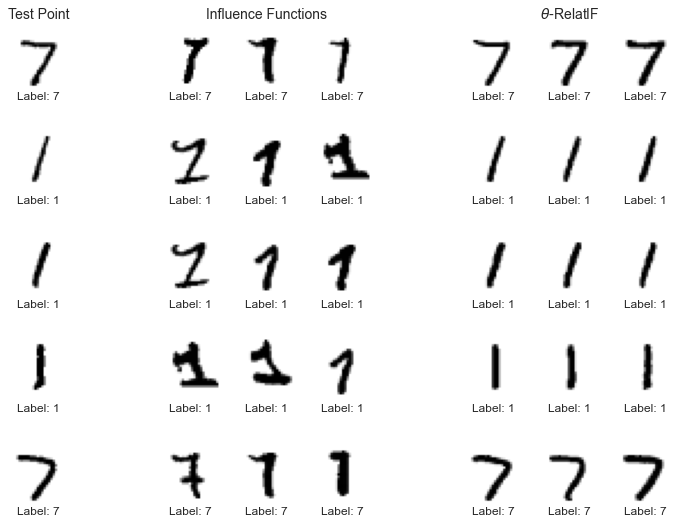

In [13]:
disp_pair(influence_idxs, theta_relatif_idxs, "Influence Functions", r"$\theta$-RelatIF")

In [14]:
def disp_single(rows, labels):
    
    num_most_influential_to_show = 3
    test_idx = 0
    
    fig, ax = plt.subplots(
        len(rows)+1,
        num_most_influential_to_show,
        subplot_kw={'xticks':[], 'yticks':[]},
        figsize=(6, 8)
    )

    plt.subplots_adjust(hspace=1.2)
    
    for j in range(num_most_influential_to_show):
        ax[0, j].set_visible(False)
    
    ax[0, (num_most_influential_to_show-1)//2].set_visible(True)
    ax[0, (num_most_influential_to_show-1)//2].imshow(test_images[test_idx], cmap=plt.cm.binary)
    ax[0, (num_most_influential_to_show-1)//2].set_title("Test Point", fontdict={'fontsize': 14})
    ax[0, (num_most_influential_to_show-1)//2].set_xlabel("Label: {}".format(test_labels[test_idx]))

    for i in range(len(rows)):

        ax[i+1, (num_most_influential_to_show-1)//2].set_title(labels[i], fontdict={'fontsize': 14})    

        for j in range(num_most_influential_to_show):
            ax[i+1, j].imshow(train_images[rows[i][j, test_idx]], cmap=plt.cm.binary)
            ax[i+1, j].set_xlabel("Label: {}".format(train_labels[rows[i][j, test_idx]]))

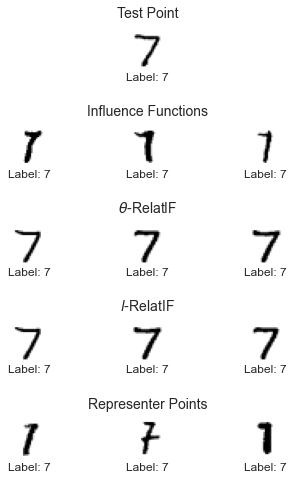

In [15]:
rows = [influence_idxs, theta_relatif_idxs, l_relatif_idxs, representer_idxs]
labels = ["Influence Functions", r"$\theta$-RelatIF", r"$l$-RelatIF", "Representer Points"]
disp_single(rows, labels)

In [16]:
def disp_all(cols, labels):
    
    num_test_points_to_show = 5
    num_most_influential_to_show = 3
    
    fig, ax = plt.subplots(
        num_test_points_to_show,
        (len(cols)*(num_most_influential_to_show+1)+1),
        subplot_kw={'xticks':[], 'yticks':[]},
        figsize=(16, 9)
    )

    ax[0, 0].set_title("Test Point", fontdict={'fontsize': 14})
    
    for j in range(num_test_points_to_show):
        ax[j, 0].imshow(test_images[j], cmap=plt.cm.binary)
        ax[j, 0].set_xlabel("Label: {}".format(test_labels[j]))
    
    for i in range(len(cols)):
        start_col_idx = 2 + i*(num_most_influential_to_show+1)        
        ax[0, start_col_idx+num_most_influential_to_show//2].set_title(labels[i], fontdict={'fontsize': 14})
        
        for j in range(num_test_points_to_show):
            ax[j, start_col_idx-1].set_visible(False)
            for k in range(num_most_influential_to_show):
                ax[j, start_col_idx+k].imshow(train_images[cols[i][k, j]], cmap=plt.cm.binary)
                ax[j, start_col_idx+k].set_xlabel("Label: {}".format(train_labels[cols[i][k, j]]))
                
    fig.savefig(
        "../output/disp_all_{}".format(datetime.now().strftime("%Y_%m_%d_%H_%M_%S")),
        dpi=300,
        bbox_inches="tight",
    )

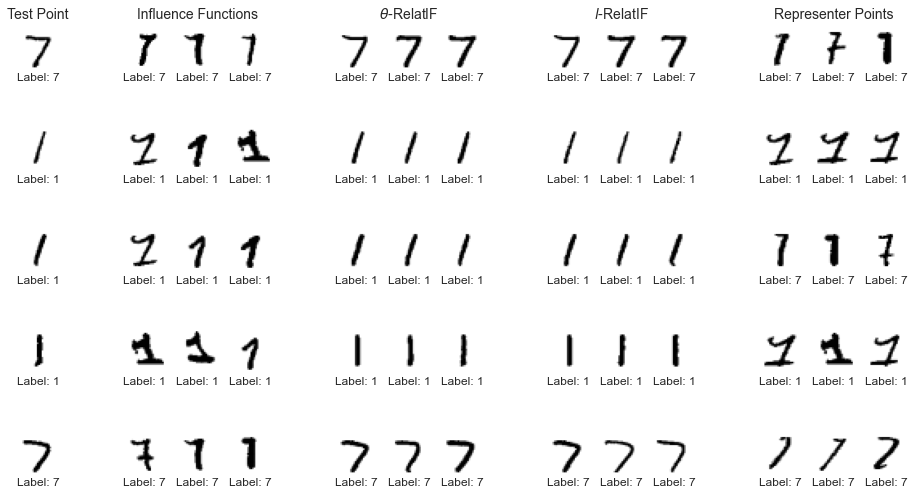

In [17]:
disp_all(rows, labels)

## Visualising Most Globally Influential Points

In [18]:
global_influence = np.argsort(np.sum(influence_values, axis=1))
global_theta_relatif = np.argsort(np.sum(theta_relatif_values, axis=1))
global_l_relatif = np.argsort(np.sum(l_relatif_values, axis=1))

global_representer = np.flip(np.argsort(np.sum(representer_values, axis=1)))

In [19]:
def disp_most_globally_influential(idxs):
    
    num_most_influential_to_show = 5
    
    pos_idxs = idxs
    neg_idxs = np.flip(pos_idxs)
    
    fig, ax = plt.subplots(
        2,
        num_most_influential_to_show,
        subplot_kw={'xticks':[], 'yticks':[]},
        figsize=(8, 6)
    )

    ax[0, (num_most_influential_to_show-1)//2].set_title("Most Positive Examples", fontdict={'fontsize': 14})
    ax[1, (num_most_influential_to_show-1)//2].set_title("Most Negative Examples", fontdict={'fontsize': 14})

    for i in range(num_most_influential_to_show):
        ax[0, i].imshow(train_images[pos_idxs[i]], cmap=plt.cm.binary)        
        ax[0, i].set_xlabel("Label: {}".format(train_labels[pos_idxs[i]]))
        # ax[0, i].set_ylabel("idx: {}".format(pos_idxs[i]))

        ax[1, i].imshow(train_images[neg_idxs[i]], cmap=plt.cm.binary)
        ax[1, i].set_xlabel("Label: {}".format(train_labels[neg_idxs[i]]))
        # ax[1, i].set_ylabel("idx: {}".format(neg_idxs[i]))

### Influence Functions

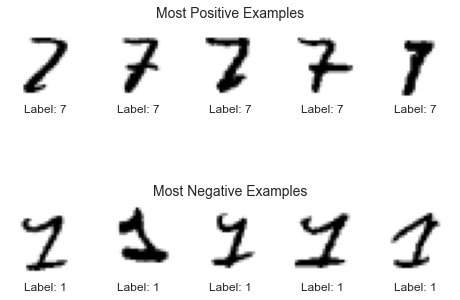

In [20]:
disp_most_globally_influential(global_influence)

### $\theta$-RelatIF

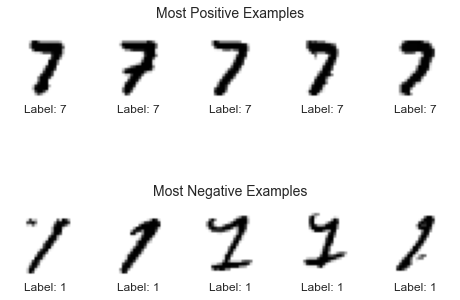

In [21]:
disp_most_globally_influential(global_theta_relatif)

### $l$-RelatIF

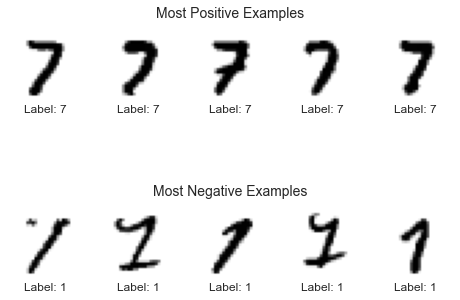

In [22]:
disp_most_globally_influential(global_l_relatif)

### Representer Points

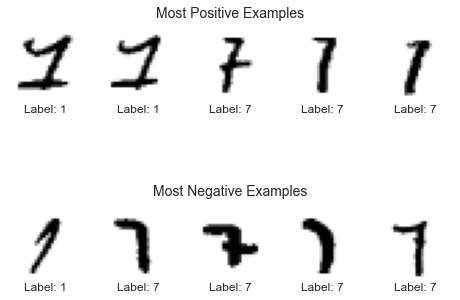

In [23]:
disp_most_globally_influential(global_representer)

## Comparing Number of Unique Points

In [24]:
influential_to_compare = [1, 5, 10]
idxs_to_compare = [influence_idxs, theta_relatif_idxs, l_relatif_idxs, representer_idxs]
labels = ["Influence Functions", r"$\theta$-RelatIF", r"$l$-RelatIF", "Representer Points"]

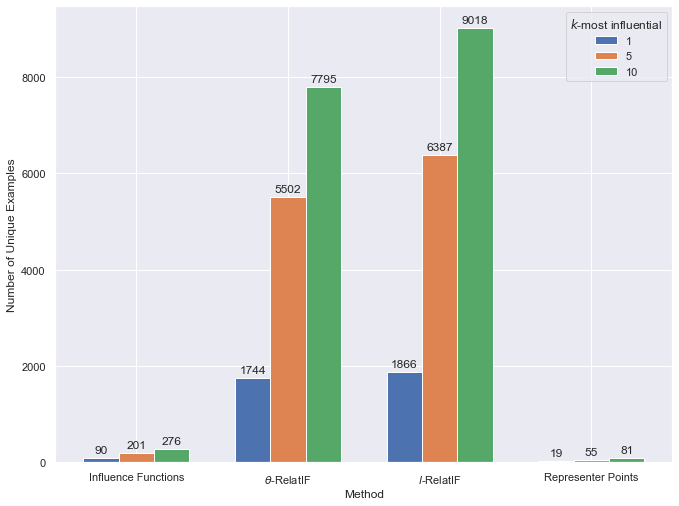

In [25]:
fig, ax = plt.subplots(figsize=(9.6, 7.2))

x = np.arange(len(idxs_to_compare))
width = 0.7 / len(influential_to_compare)

for i in range(len(influential_to_compare)):
    
    num_unique = [len(np.unique(j[:influential_to_compare[i], :num_test_points])) for j in idxs_to_compare]
    rects = ax.bar(x+i*width, num_unique, width, label=str(influential_to_compare[i]))
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_ylabel("Number of Unique Examples")
ax.set_xlabel("Method")
ax.set_xticks(x+0.35-width/2)
ax.set_xticklabels(labels)
ax.legend(title=r"$k$-most influential")
fig.tight_layout()

fig.savefig(
    "../output/unique_points_{}".format(datetime.now().strftime("%Y_%m_%d_%H_%M_%S")),
    dpi=300,
    bbox_inches="tight",
)

## Comparing Average Distance Between Pairs of Influential Points

In [26]:
influential_to_compare = [3, 5, 10]
idxs_to_compare = [influence_idxs, theta_relatif_idxs, l_relatif_idxs, representer_idxs]
labels = ["Influence Functions", r"$\theta$-RelatIF", r"$l$-RelatIF", "Representer Points"]

In [27]:
bar_heights = []

for i in range(len(influential_to_compare)):    
    
    avg_pair_distance = []
    
    for idxs in idxs_to_compare:
        pair_distances = []
        for j in range(num_test_points):
            for k in range(influential_to_compare[i]):
                for l in range(k, influential_to_compare[i]):
                    difference = train_images[idxs[k, j]] - train_images[idxs[l, j]]
                    pair_distances.append(np.linalg.norm(difference))
        avg_pair_distance.append(np.mean(pair_distances))
    bar_heights.append(avg_pair_distance)
        
num_random_samples = 1000

random_idxs = np.random.choice(len(train_images), size=(2, num_random_samples))
pair_distances = [
    np.linalg.norm(train_images[random_idxs[0, i]] - train_images[random_idxs[1, i]])
    for i in range(num_random_samples)
]
random_avg_pair_distances = np.mean(pair_distances)

pair_distances = []
for j in [1, 7]:
    random_idxs = np.random.choice(
        len(train_images[train_labels == j]), size=(2, num_random_samples)
    )
    pair_distances += [
        np.linalg.norm(
            train_images[train_labels == j][random_idxs[0, i]]
            - train_images[train_labels == j][random_idxs[1, i]]
        )
        for i in range(num_random_samples)
    ]
in_class_avg_pair_distances = np.mean(pair_distances)

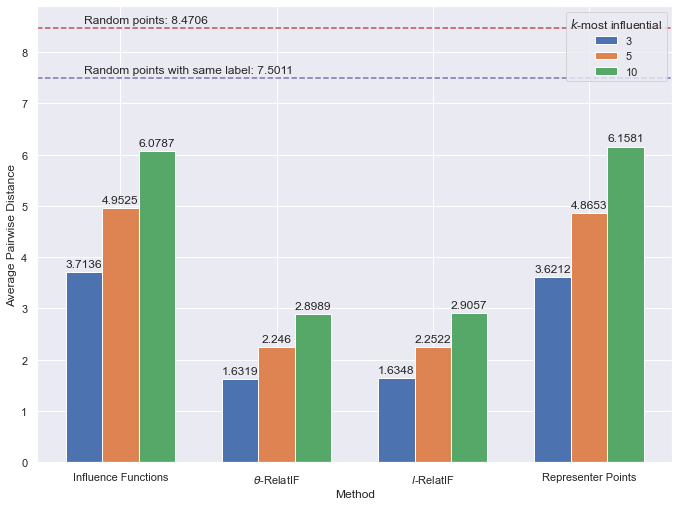

In [28]:
fig, ax = plt.subplots(figsize=(9.6, 7.2))

x = np.arange(len(idxs_to_compare))
width = 0.7 / len(influential_to_compare)

for i in range(len(influential_to_compare)):
    
    rects = ax.bar(x+i*width, bar_heights[i], width, label=str(influential_to_compare[i]))
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.5g}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')        

ax.axhline(random_avg_pair_distances, linestyle="--", c="C3")
ax.annotate("Random points: {:.5g}".format(random_avg_pair_distances),
            xy=(0, random_avg_pair_distances),
            xytext=(0, 3),
            textcoords="offset points",
            ha='left', va='bottom')


ax.axhline(in_class_avg_pair_distances, linestyle="--", c="C4")
ax.annotate("Random points with same label: {:.5g}".format(in_class_avg_pair_distances),
            xy=(0, in_class_avg_pair_distances),
            xytext=(0, 3),
            textcoords="offset points",
            ha='left', va='bottom')

ax.set_ylabel("Average Pairwise Distance")
ax.set_xlabel("Method")
ax.set_xticks(x+0.35-width/2)
ax.set_xticklabels(labels)
ax.legend(title=r"$k$-most influential", loc="upper right")
fig.tight_layout()

fig.savefig(
    "../output/average_distances_{}".format(datetime.now().strftime("%Y_%m_%d_%H_%M_%S")),
    dpi=300,
    bbox_inches="tight",
)

## Comparing Similarity Between Approaches

In [34]:
values_to_compare = [influence_values, theta_relatif_values, l_relatif_values, representer_values]
labels = ["Influence Functions", r"$\theta$-RelatIF", r"$l$-RelatIF", "Representer Points"]

for i in range(len(idxs_to_compare)):
    for j in range(i):
        tau, pvalue = kendalltau(values_to_compare[i], values_to_compare[j])
        print(r"Kendall's $\tau$ of {} and {} = {:.5g}".format(labels[i], labels[j], tau))

Kendall's $\tau$ of $\theta$-RelatIF and Influence Functions = 0.77875
Kendall's $\tau$ of $l$-RelatIF and Influence Functions = 0.77686
Kendall's $\tau$ of $l$-RelatIF and $\theta$-RelatIF = 0.98952
Kendall's $\tau$ of Representer Points and Influence Functions = 0.62238
Kendall's $\tau$ of Representer Points and $\theta$-RelatIF = 0.49951
Kendall's $\tau$ of Representer Points and $l$-RelatIF = 0.49731
